# Identificación de Retinopatía Diabética con MobileNet

In [35]:
from sklearn.metrics import classification_report

from tesis_lib.io.hdf5datasetgenerator import HDF5DatasetGenerator
from tesis_lib.datasets.rosenbrock_loader import RosenbrockLoader
from tesis_lib.callbacks.trainingmonitor import TrainingMonitor
from tesis_lib.preprocessing.imagetoarrayprocessor import ImageToArrayPreprocessor
from tesis_lib.preprocessing.aspectawareprocessor import AspectAwareProcessor
from tesis_lib.preprocessing.patchpreprocessor import PatchPreprocessor
from tesis_lib.preprocessing.meanpreprocessor import MeanPreprocessor
from tesis_lib.preprocessing.simplepreprocessor import SimpleProcessor

import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, Dropout, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import MobileNet, VGG16
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import progressbar
import json
import cv2
import os

In [36]:
TIME_STAMP = datetime.today().strftime("%d_%m_%Y_%H_%M")

In [37]:
DATASET_PATH = './DB'

FILENAME = f'ident_mobilenet_{TIME_STAMP}'

MODEL_OUT_PATH = f'./models/{FILENAME}.h5'
OUTPUT_PATH = F'./output/{FILENAME}'

BATCH_SIZE = 32
EPOCHS = 50
IM_SIZE = 300
NUM_CLASSES = 4

LEARNING_RATE = 1e-3
DROP_FACTOR = 0.10
DROP_EPOCHS = 10

In [38]:
report_dict = {
    'learning-rate' : str(LEARNING_RATE),
    'epochs': EPOCHS,
    'image-size': IM_SIZE,
    'batch-size': BATCH_SIZE,
    'data': {}
}

Found 2251 images belonging to 4 classes.
Found 1400 images belonging to 4 classes.
Found 1432 images belonging to 4 classes.
[INFO] train example images


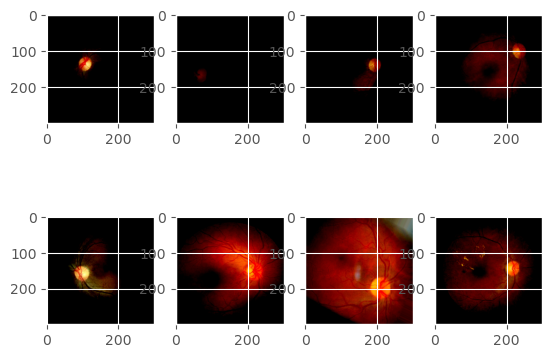

[INFO] val example images


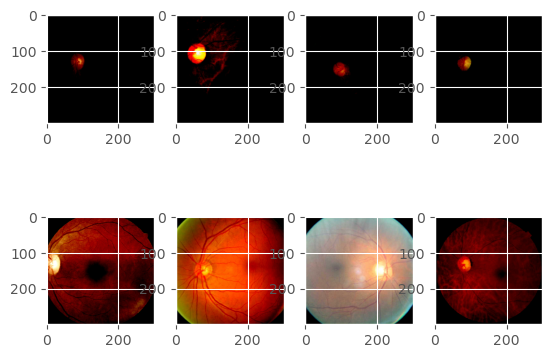

[INFO] test example images


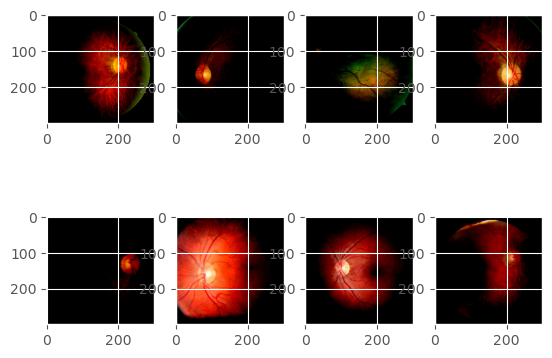

In [39]:
import random

train_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    # rescale=1./255,
    rotation_range=25, 
    # shear_range=0.20, 
    zoom_range=0.15,
    # width_shift_range=0.1,
    # height_shift_range=0.1, 
    horizontal_flip=True, 
    fill_mode='nearest'
).flow_from_directory(
    directory=os.path.sep.join([DATASET_PATH, 'Train']),
    target_size=(IM_SIZE,IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    keep_aspect_ratio=True
)


val_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    # rescale=1./255,
).flow_from_directory(
    directory=os.path.sep.join([DATASET_PATH, 'Val']),
    target_size=(IM_SIZE,IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    keep_aspect_ratio=True
)
test_batches = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    # rescale=1./255,
).flow_from_directory(
    directory=os.path.sep.join([DATASET_PATH, 'Test']),
    target_size=(IM_SIZE,IM_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    keep_aspect_ratio=True
)

def explore(batch: tuple, title:str):
    print(f"[INFO] {title} example images")
    example_batch, _ = batch[0]

    index = random.randint(0,24)
    for i, img in enumerate(example_batch[index:index+8]):
        plt.subplot(2,4,i+1)
        plt.imshow(img)

    plt.show()

explore(train_batches,'train')
explore(val_batches, 'val')
explore(test_batches, 'test')

In [40]:
if not os.path.exists(OUTPUT_PATH):
    os.mkdir(OUTPUT_PATH)

In [41]:
print("[INFO] Compiling model ...")

opt = Adam(lr=LEARNING_RATE)

DROPOUT_RATE = 0.5

model = MobileNet(
    input_shape=(IM_SIZE,IM_SIZE,3),
    alpha=1.0,
    include_top=True,
    weights=None,
    pooling='max',
    classes=NUM_CLASSES,
    classifier_activation='softmax'
)

# model = tf.keras.Sequential([
#     base_model,
#     Dropout(0.5),
#     Dense(NUM_CLASSES, activation='softmax')
# ])

model.compile(
    loss="categorical_crossentropy",
    optimizer=opt,
    metrics=["accuracy"]
)

monitor_path = os.path.sep.join([OUTPUT_PATH,f"{FILENAME}.jpg"])

checkpoint = ModelCheckpoint(
    MODEL_OUT_PATH, 
    monitor="val_loss", 
    mode='min', 
    save_best_only=True,
    verbose=1)

callbacks = [
    checkpoint,
    TrainingMonitor(monitor_path)
]

display(model.summary())

print(f"[INFO] training model ...")

H = model.fit(
    x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=val_batches,
    validation_steps=len(val_batches),
    epochs= EPOCHS,
    max_queue_size=10,
    callbacks=callbacks,
    shuffle=True,
    verbose=1
)

[INFO] Compiling model ...
Model: "mobilenet_1.00_300"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 150, 150, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 150, 150, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 150, 150, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 150, 150, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 150, 150, 32)     128       
 ation)              

None

[INFO] training model ...
Epoch 1/50
71/71 [==============================] - ETA: 0s - loss: 1.4649 - accuracy: 0.2470
Epoch 1: val_loss improved from inf to 1.40864, saving model to ./models/ident_mobilenet_02_02_2023_13_49.h5
71/71 [==============================] - 126s 2s/step - loss: 1.4649 - accuracy: 0.2470 - val_loss: 1.4086 - val_accuracy: 0.2529
Epoch 2/50
71/71 [==============================] - ETA: 0s - loss: 1.4497 - accuracy: 0.2625
Epoch 2: val_loss did not improve from 1.40864
71/71 [==============================] - 122s 2s/step - loss: 1.4497 - accuracy: 0.2625 - val_loss: 1.5919 - val_accuracy: 0.2529
Epoch 3/50
71/71 [==============================] - ETA: 0s - loss: 1.4381 - accuracy: 0.2554
Epoch 3: val_loss did not improve from 1.40864
71/71 [==============================] - 122s 2s/step - loss: 1.4381 - accuracy: 0.2554 - val_loss: 1.7347 - val_accuracy: 0.2529
Epoch 4/50
71/71 [==============================] - ETA: 0s - loss: 1.4272 - accuracy: 0.2754
Epoch

## Making predictions and evaluating the model

In [42]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    MATRIX_PATH = os.path.sep.join([OUTPUT_PATH, f'cm-{FILENAME}.jpg'])
    plt.savefig(MATRIX_PATH)
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, class_likelihood_ratios

# from tesis_lib.io.hdf5datasetgenerator import HDF5DatasetGenerator
# from tesis_lib.preprocessing.simplepreprocessor import SimpleProcessor
# from tesis_lib.preprocessing.meanpreprocessor import MeanPreprocessor
# from tesis_lib.preprocessing.croppreprocessor import CropPreprocessor
# from tesis_lib.preprocessing.imagetoarrayprocessor import ImageToArrayPreprocessor

from tesis_lib.utils.ranked import rank5_accuracy
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
# import numpy as np
# import progressbar
# import json

BATCH_SIZE = 32
IM_SIZE = 256
NUM_CLASSES = 2

# means = json.loads(open('./DB/hdf5/diat_ret.json').read())

# sp = SimpleProcessor(IM_SIZE, IM_SIZE)
# mp = MeanPreprocessor(means["R"], means["G"], means["B"])
# iap = ImageToArrayPreprocessor()

# load the pretrained network
print(f"[INFO] loading model {MODEL_OUT_PATH}...")
model = load_model(MODEL_OUT_PATH)

# initialize the testing dataset generator, then make predictions on
# the testing data
print("[INFO] predicting on test data (no crops)...")

# testGen = HDF5DatasetGenerator(
# 	'./DB/hdf5/Testing.hdf5',
# 	BATCH_SIZE,
# 	preprocessors=[sp, mp, iap],
# 	classes=NUM_CLASSES)

predictions = model.predict(test_batches)

trueLabels = test_batches.classes
predictedLabels = list(predictions.argmax(axis=1))



[INFO] rank-1: 40.08%


[INFO] Calculating Confusion Matrix
Confusion matrix, without normalization
[[164 113  22  68]
 [ 90 170  14  80]
 [ 91 116  50 100]
 [ 58  80  26 190]]


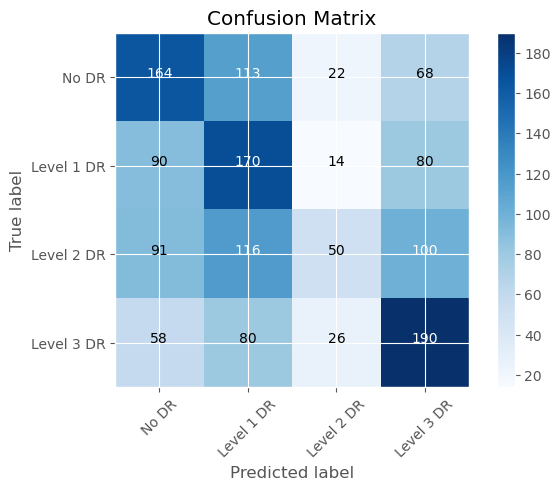

[INFO] Generating the Classification Report
              precision    recall  f1-score   support

       No DR       0.41      0.45      0.43       367
  Level 1 DR       0.35      0.48      0.41       354
  Level 2 DR       0.45      0.14      0.21       357
  Level 3 DR       0.43      0.54      0.48       354

    accuracy                           0.40      1432
   macro avg       0.41      0.40      0.38      1432
weighted avg       0.41      0.40      0.38      1432



In [49]:
# compute the rank-1 and rank-5 accuracies
(rank1, _) = rank5_accuracy(predictions, trueLabels)
print("[INFO] rank-1: {:.2f}%".format(rank1 * 100))

# testGen.close()

print("\n\n[INFO] Calculating Confusion Matrix")
cm = confusion_matrix(
    y_true = trueLabels,
    y_pred = predictedLabels
)
plot_confusion_matrix(cm, ['No DR', 'Level 1 DR', 'Level 2 DR', 'Level 3 DR'], False, "Confusion Matrix")

print("[INFO] Generating the Classification Report")
print(classification_report(
	y_true = trueLabels,
	y_pred = predictedLabels,
	target_names= ['No DR', 'Level 1 DR', 'Level 2 DR', 'Level 3 DR']
))